## Assignment 1 
### Putri Khalilah binti Kamaluddin a1873127

In [1]:
# import package/libraries
import string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, confusion_matrix,recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import regex as re
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from nltk.sentiment import SentimentIntensityAnalyzer

import spacy
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

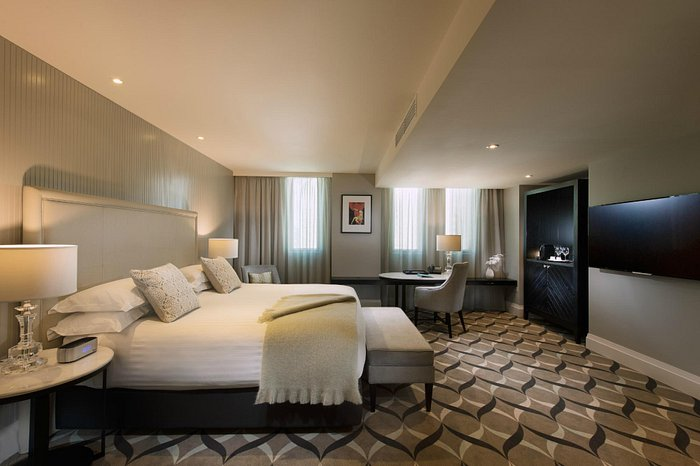

## Purpose

The dataset is contain a hotel reviews. Hotel Reviews is an essential component for the future hotel guests so they could understand if the hotel that they are planning to book is providing best or worst services. Reviews is a form of textual comments that leave by the guests that had experienced it. Analyzing the reviews of the hotels provides the opinion of the hotel guests towards the hotel that they stayed. Studying the sentiment expressed in these comments show if the hotel is getting positive or negative feedback.

## Task

Predict sentiment (positive or negative) based on <b>"overall"</b> score using <b>“title”</b> field concatenated with <b>“text”</b> field.

### 1. Reading datasets using file object

In [2]:
# read the JSON data
import json
data = []
with open("random_30000_hotel_reviews.JSON", 'r') as f:
    for line in f:
        # Parse each line as JSON and append it to the list
        data.append(json.loads(line))

In [3]:
# Source - https://stackoverflow.com/questions/40588852/how-to-read-a-json-file-with-nested-objects-as-a-pandas-dataframe
df = pd.json_normalize(data) # flatten the json object
df.head(3)

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_reviews,author.id,author.location,author.num_cities,author.num_helpful_votes,author.num_type_reviews,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,September 2012,80138,0,"September 19, 2012",140716137,False,1.0,2.0,...,1.0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,June 2011,240151,1,"June 27, 2011",114807323,False,1.0,1.0,...,NaN,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,October 2010,80793,0,"October 25, 2010",84805430,False,4.0,5.0,...,4.0,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0,NaN,NaN


In [4]:
print(df.columns)

Index(['title', 'text', 'date_stayed', 'offering_id', 'num_helpful_votes',
       'date', 'id', 'via_mobile', 'ratings.service', 'ratings.cleanliness',
       'ratings.overall', 'ratings.value', 'ratings.location',
       'ratings.sleep_quality', 'ratings.rooms', 'author.username',
       'author.num_reviews', 'author.id', 'author.location',
       'author.num_cities', 'author.num_helpful_votes',
       'author.num_type_reviews', 'ratings.check_in_front_desk',
       'ratings.business_service_(e_g_internet_access)'],
      dtype='object')


### 1.1 filter to ratings.overall, title and text columns

In [5]:
df = df[['title','text','ratings.overall']]
# rename ratings.overall to overall rating
df = df.rename(columns={"ratings.overall":"overall_rating"})
df

,title,text,overall_rating
0,“Horrible experience”,First of all we got there and they didn't have...,1.0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,1.0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,4.0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,2.0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",1.0
...,...,...,...
29995,“Felt right at home here”,I've stayed at many downtown Chicago hotels. T...,5.0
29996,“Days Inn Chicago 101212”,It is always a pleasant stay at your facility....,5.0
29997,“Upgrades Needed”,We recently stayed here for a girls' weekend. ...,2.0
29998,“perfect bargain city hotel”,I made my reservation online at the Bijou beca...,5.0


### 1.2 concatenated title and text columns

In [6]:
df["title_text"] = df['title'] + ' ' + df['text']
df.head(5)

,title,text,overall_rating,title_text
0,“Horrible experience”,First of all we got there and they didn't have...,1.0,“Horrible experience” First of all we got ther...
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,1.0,“Stay Away” Found Racist graffiti in the room....
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,4.0,“Great location and service” Close to Union Sq...
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,2.0,“I will never go back here again!” I had a bad...
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",1.0,“Ripped off our VISA card after departure” Aft...


### 1. 3 Split data
#### Into training (first 10000 lines), development (next 10000 lines) and test (remaining 10000 lines).

In [7]:
# source - https://datacarpentry.org/python-ecology-lesson/03-index-slice-subset.html
development = df.iloc[:10000,:].copy()# temporarily do 100 for faster process
train = df.iloc[10000:20000,:].copy()
test = df.iloc[20000:,:].copy()

# checking the length of each dataset
print(len(development),len(train),len(test))

10000 10000 10000


### 1. 4 Remove all non-alphanumeric characters

In [8]:
# source - https://stackoverflow.com/questions/10868308/regular-expression-a-za-z0-9

# Clean the text by stripping the spaces at beginning and ending of the sentences.
development["title_text"] = development["title_text"].str.lstrip().str.rstrip()
train["title_text"] = train["title_text"].str.lstrip().str.rstrip()
test["title_text"] = test["title_text"].str.lstrip().str.rstrip()
    
# Define a regular expression pattern to match non-alphanumeric characters
pattern = r'[^a-zA-Z0-9\s]'
development['title_text_rm_non_alpha'] = development['title_text'].apply(lambda x: re.sub(pattern, '', x))
train['title_text_rm_non_alpha'] = train['title_text'].apply(lambda x: re.sub(pattern, '', x))
test['title_text_rm_non_alpha'] = test['title_text'].apply(lambda x: re.sub(pattern, '', x))

# Display the DataFrame
development.head(5)

,title,text,overall_rating,title_text,title_text_rm_non_alpha
0,“Horrible experience”,First of all we got there and they didn't have...,1.0,“Horrible experience” First of all we got ther...,Horrible experience First of all we got there ...
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,1.0,“Stay Away” Found Racist graffiti in the room....,Stay Away Found Racist graffiti in the room Re...
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,4.0,“Great location and service” Close to Union Sq...,Great location and service Close to Union Squa...
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,2.0,“I will never go back here again!” I had a bad...,I will never go back here again I had a bad vi...
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",1.0,“Ripped off our VISA card after departure” Aft...,Ripped off our VISA card after departure After...


### 1. 5 Number of characters present in each sentence

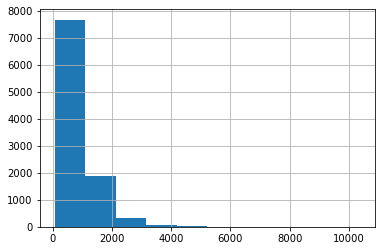

In [9]:
development['title_text_rm_non_alpha'].str.len().hist()
plt.show()

The histogram shows that reviews range from 500 to 3500 characters and generally, it is between 500 to 1000 characters.

### 1. 5 Tokenize the text

In [10]:
development["tokenized_text"] = development['title_text_rm_non_alpha'].apply(lambda x: nltk.tokenize.word_tokenize(x))                                      

# Calculate the length of each list of words in the DataFrame row
development['word_list_length'] = development['tokenized_text'].apply(lambda x: len(x))

# Display the DataFrame with the calculated lengths
development.head(10)


,title,text,overall_rating,title_text,title_text_rm_non_alpha,tokenized_text,word_list_length
0,“Horrible experience”,First of all we got there and they didn't have...,1.0,“Horrible experience” First of all we got ther...,Horrible experience First of all we got there ...,"[Horrible, experience, First, of, all, we, got...",206
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,1.0,“Stay Away” Found Racist graffiti in the room....,Stay Away Found Racist graffiti in the room Re...,"[Stay, Away, Found, Racist, graffiti, in, the,...",65
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,4.0,“Great location and service” Close to Union Sq...,Great location and service Close to Union Squa...,"[Great, location, and, service, Close, to, Uni...",55
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,2.0,“I will never go back here again!” I had a bad...,I will never go back here again I had a bad vi...,"[I, will, never, go, back, here, again, I, had...",326
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",1.0,“Ripped off our VISA card after departure” Aft...,Ripped off our VISA card after departure After...,"[Ripped, off, our, VISA, card, after, departur...",46
5,“A great location!”,"Steps to Grand Central, a very well situated h...",4.0,"“A great location!” Steps to Grand Central, a ...",A great location Steps to Grand Central a very...,"[A, great, location, Steps, to, Grand, Central...",22
6,“It's all about the Location”,This Hotel is located right in the heart of Sa...,3.0,“It's all about the Location” This Hotel is lo...,Its all about the Location This Hotel is locat...,"[Its, all, about, the, Location, This, Hotel, ...",378
7,“Five Star Service”,I stayed with my teenage boys at the resort fo...,5.0,“Five Star Service” I stayed with my teenage b...,Five Star Service I stayed with my teenage boy...,"[Five, Star, Service, I, stayed, with, my, tee...",126
8,“Good airport hotel in Seattle”,Very good airporrt hotel. Comfortable bed; nic...,4.0,“Good airport hotel in Seattle” Very good airp...,Good airport hotel in Seattle Very good airpor...,"[Good, airport, hotel, in, Seattle, Very, good...",180
9,“Grand Union Hotel”,"Just returned from a great trip to New York,We...",3.0,“Grand Union Hotel” Just returned from a great...,Grand Union Hotel Just returned from a great t...,"[Grand, Union, Hotel, Just, returned, from, a,...",126


### 2. Exploratory Data Analysis (EDA)

Distribution of <b>"overall"</b> rating over number of instances, number of unique words, predictive words, non-predictive words. You may perform some preprocessing on a sample of data (to speed up the analysis) if that is needed for EDA.

### 2.1 Distribution of "overall" rating

This histogram visualizes the distribution of "Overall Ratings". It shows how frequently each rating appears in the dataset. It helps understand the distribution of opinions about the hotel reviews.

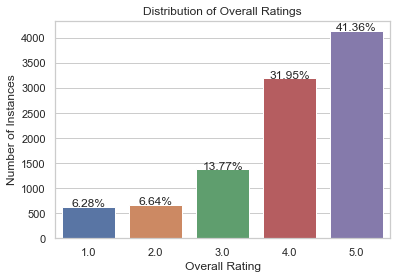

In [11]:
# Display distribution of overall rating
sns.set(style="whitegrid")  # Optional: set the style of the plot
ax = sns.countplot(x='overall_rating', data=development)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')

# Calculate percentage for each rating category
total = float(len(development))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.2f}%'.format((height / total) * 100),
            ha="center")

plt.show()

The histogram shows that overall rating with 5.0 has the highest count in the dataset. Almost 40% of the development dataset have the 5.0 rating. This shows that hotel guests had a good experience staying at the hotel. While with rating of 1.0 and 2.0 around 12% of the dataset. This low percentage for these rating counts show that the hotel guest have less accountered with unpleasant experience.

In [12]:
# Count of the class of overall rating.
development['overall_rating'].value_counts()

5.0    4136
4.0    3195
3.0    1377
2.0     664
1.0     628
Name: overall_rating, dtype: int64

### 2.2 Hotel Review Word Lengths

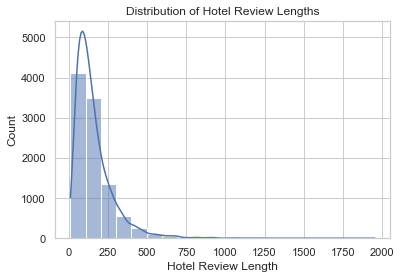

In [13]:
# Analyze the distribution of hotel review lengths
sns.histplot(development['word_list_length'], bins=20, kde=True)
plt.title('Distribution of Hotel Review Lengths')
plt.xlabel('Hotel Review Length')
plt.show()

### 2.3 Checking the frequent words

FreqDist in NLTK provides the top distribution of words in a group of words.

In [14]:
def get_str_list(ser):
    str_all = ' '.join(list(ser))
    return str_all
    
words = get_str_list(development["title_text_rm_non_alpha"])
words = nltk.tokenize.word_tokenize(words)
fdist = FreqDist(words)
fdist.most_common()

[('the', 81827),
 ('and', 54771),
 ('a', 43867),
 ('to', 39838),
 ('was', 33786),
 ('I', 24860),
 ('in', 24743),
 ('of', 21482),
 ('The', 20435),
 ('is', 19511),
 ('for', 19010),
 ('hotel', 17887),
 ('room', 14816),
 ('we', 13138),
 ('it', 12867),
 ('at', 12582),
 ('were', 11677),
 ('with', 11665),
 ('but', 11221),
 ('on', 11136),
 ('that', 10888),
 ('very', 10372),
 ('you', 9534),
 ('not', 9216),
 ('this', 9199),
 ('had', 8866),
 ('We', 8581),
 ('are', 7682),
 ('have', 7542),
 ('stay', 7480),
 ('our', 7239),
 ('from', 6851),
 ('great', 6616),
 ('my', 6580),
 ('staff', 6228),
 ('as', 6111),
 ('there', 5929),
 ('be', 5821),
 ('so', 5469),
 ('location', 5394),
 ('they', 5215),
 ('all', 5072),
 ('would', 5053),
 ('rooms', 4897),
 ('nice', 4701),
 ('good', 4699),
 ('one', 4252),
 ('clean', 4164),
 ('out', 4111),
 ('an', 4004),
 ('us', 3905),
 ('which', 3834),
 ('service', 3793),
 ('stayed', 3784),
 ('night', 3717),
 ('if', 3689),
 ('or', 3586),
 ('just', 3422),
 ('here', 3404),
 ('up', 337

Notice the words in the hotel reviews have a lot a lot of not so useful words like “the,” “and,” and “a” are coming out as the top frequency words. These words are commonly used in all sentences, so you can’t use them to make out any meaningful intents. Such words are called <b>“stop words.”</b>  To remove this "stop words", we can import package from NLTK named stop words.

### 2.3.1 Checking the frequent words of stopwords

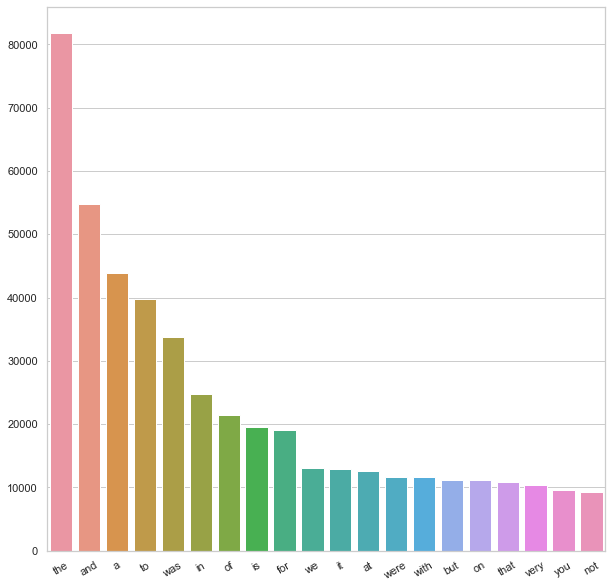

In [15]:
#source - https://dariuslfuller.medium.com/creating-visuals-with-nltks-freqdist-ac4e667e49f3

# Remove stopwords
stop_words = stopwords.words("english")

filtered_stop_words = [word for word in words if word in stop_words]
fdist = FreqDist(filtered_stop_words)
fdist = fdist.most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

### 2.3.2 Checking the frequent words on besides "stop words"

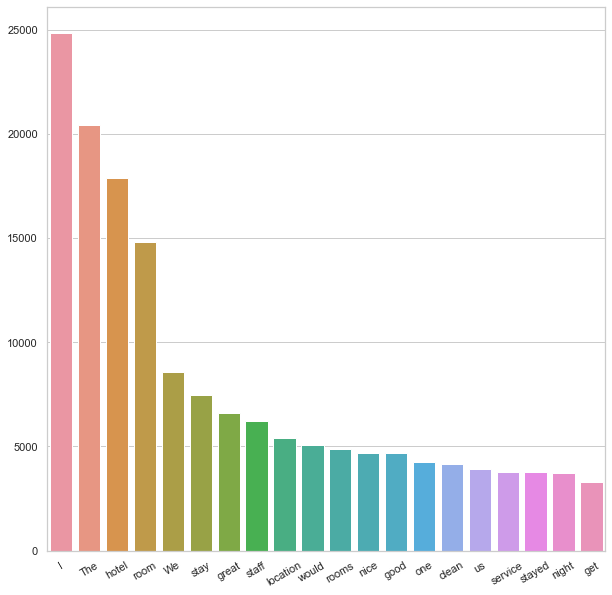

In [16]:
#source - https://dariuslfuller.medium.com/creating-visuals-with-nltks-freqdist-ac4e667e49f3

# Remove stopwords
stop_words = stopwords.words("english")

filtered_words = [word for word in words if word not in stop_words]
fdist = FreqDist(filtered_words)
fdist = fdist.most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

Even though we have removed stop words, in FreqDist output, it still shows stop words such as <b>"I"</b>, <b>"The"</b> and <b>"We"</b>. This is because stop words only captured if it in the lower case character. If we ignored these stop words, then started to see the significant words such as <b>"hotel"</b>, <b>"room"</b>, <b>"great"</b>, <b>"pricely"</b>, <b>"affordable"</b> and <b>"clean"</b>.

### 2.5 Word Cloud
Word cloud provides quick and dirty insights into the data you have.

In [17]:
# pip install --upgrade Pillow
# !pip install wordcloud

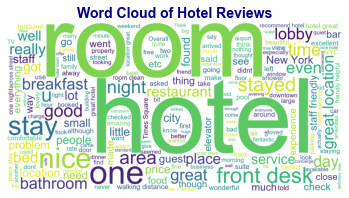

In [18]:
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(
        background_color ='white',
        relative_scaling = 1,
        width=2000, height=1000,
    font_path ='C:/Windows/Fonts/Arial.ttf').generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Word Cloud of Hotel Reviews', fontsize = 14, fontweight = 'bold', color = 'darkblue')
    plt.show()
    return wordcloud

str_all_rejoin = ' '.join(filtered_words)
str_all_rejoin[0:42]

wc = generate_wordcloud(str_all_rejoin)


We started to spot topics such as <b>hotel</b>, <b>room</b>, <b>bed</b>, <b>great location</b>, <b>staff</b>, and <b>time</b>. This is a typical topic reviews if the hotel guests reviewing if they like or dislike about the hotel they had stayed. They will comment about how good is the hotel or what is the near to the hotel vicsinity.

### 2.6 Bigrams and Trigrams
Sometimes we may also want to analyze words in a certain order. In order to retain as much meaning as possible while converting sentences to word tokens, we might also want to retain the order. So instead of having single word tokens,
we can have two- or three-term tokens. They are referred as bigrams and trigrams. Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.

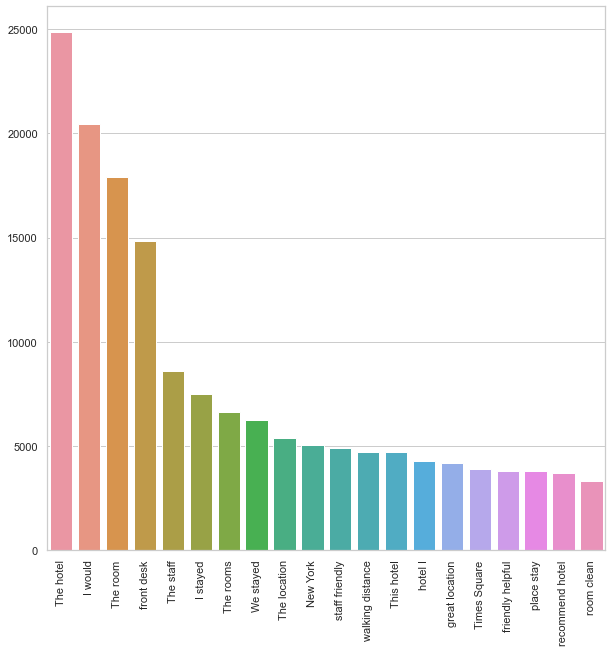

In [19]:
# Identifying common N-grams: N-grams are sequences of words. Identifying common n-grams can give insight into the most common phrases in the dataset.

from nltk import ngrams
from collections import Counter

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 2  # You can change this value to see different n-grams, e.g., 2 for bigrams, 3 for trigrams, etc.

# Generate n-grams
ngrams_list = generate_ngrams(filtered_words, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_ngrams = pd.Series(dict(ngrams_count.most_common(20)))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_ngrams.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=90);

We can observe that the bigrams such as <b>"The hotel"</b>, <b>"I would"</b> and <b>"The room"</b> that are related to hotel review dominating the bigrams. However, it did not show any important or significant word related to sentiment if it positive or negative reviews. Towards the end of the graph, we started to see the important bigrams such as <b> "front desk"</b>, <b>"walking distance"</b> and <b>"great location </b>.

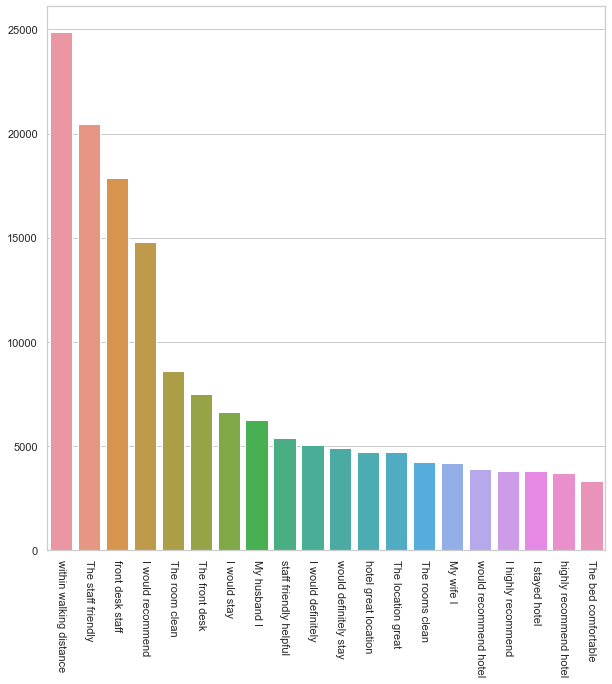

In [20]:
# Identifying common N-grams: N-grams are sequences of words. Identifying common n-grams can give insight into the most common phrases in the dataset.

from nltk import ngrams
from collections import Counter

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 3  # You can change this value to see different n-grams, e.g., 2 for bigrams, 3 for trigrams, etc.

# Generate n-grams
ngrams_list = generate_ngrams(filtered_words, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_ngrams = pd.Series(dict(ngrams_count.most_common(20)))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_ngrams.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=270);

In Trigrams, We can observe words such as <b>"within walking distance"</b>, <b>"hotel great location"</b>, <b>"The room clean"</b> and <b>"staff front desk"</b> that are related to hotel review dominate in the <b>title text</b> column. Using Trigrams produced a better words combination to capture the important or significant word related to sentiment if it positive or negative reviews.

From this graph shows that hotel with great location or within walking distance to the facilities maybe near the shopping malls, airports or public transportation and front staff of the hotel dominates the trigrams model in this hotel reviews datasets. This might be potential aspects of the hotel reviews that contribute to the overall rating.

### 3. Preprocessing and Machine Learning method selection

### 3.1 Creating 'sentiment' column from the rating
This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative. Assigning overall ratings to these sentiments, will give a overall idea how positive sentiment words would look like and compare it with negative. Remove the reviews with overall rating of 3 as they are considered as neutral.

In [21]:
def rating_to_sentiment(row):
    
    if row['overall_rating'] < 3.0:
        val = 0 # Negative
    elif row['overall_rating'] == 4.0 or row['overall_rating'] == 5.0:
        val = 1 # Positive
    else:
        val = -1 # Neutral
    return val

# Apply the function to the text column
development["sentiment"] =  development.apply(rating_to_sentiment, axis = 1)

# Filter out -1 or Neutral comment
development = development[development['sentiment'] != -1]

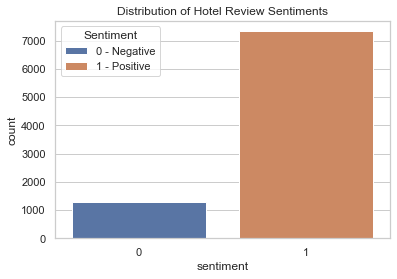

In [22]:
# source : https://stackoverflow.com/questions/61445146/why-is-my-legend-in-my-seaborn-countplot-not-showing-all-the-labels?newreg=89c6cf35d91643509d6c0c57733a149e

# Display distribution of overall rating
ax = sns.countplot(data=development, x="sentiment", hue='sentiment', dodge=False) 
h,l = ax.get_legend_handles_labels()
labels=["0 - Negative", "1 - Positive"]
ax.legend(h,labels,title="Sentiment", loc="upper left") 
plt.title('Distribution of Hotel Review Sentiments')
plt.show()

Notice our data is not balance for each sentiment class. Need to balance the dataset using SMOTE algorithm in order to balance the probability of predicting a sentiment to 50%.

### 3.2 Removing Non-English reviews to reduce processing error
The need to filter out Non-English reviews because vast majority of technological advances have been achieved in English-based NLP systems.

In [23]:
# pip install langdetect

In [24]:
# https://stackoverflow.com/questions/69804094/drop-non-english-rows-pandas
from langdetect import detect, detect_langs
# detect("War doesn't show who's right, just who's left")
# detect_langs("War doesn't show who's right, just who's left")

# Detect the language on the review column
development['detect_lang'] = development['title_text_rm_non_alpha'].apply((lambda x: detect(x)))

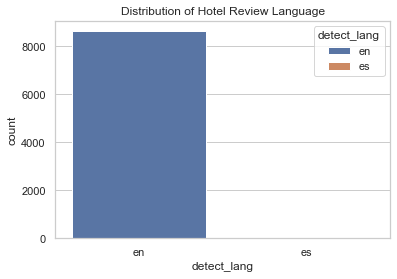

In [25]:
# Count the reviews by language

ax = sns.countplot(data=development, x="detect_lang", hue='detect_lang', dodge=False) 
h,l = ax.get_legend_handles_labels()
plt.title('Distribution of Hotel Review Language')
plt.show()

In [26]:
# Count of the language count.
development['detect_lang'].value_counts()

en    8622
es       1
Name: detect_lang, dtype: int64

Almost all the reviews in the development dataset are in English language. We shall drop non-english row if present in order to proceed to next processing.

In [27]:
# Filter out non-english reviews
development = development[development['detect_lang'] == 'en']

### 3.3 Preprocessing the dataset using stop words removal, lemmatisation and lowercasing

In the pre-processing task, we will have 3 different datasets to begin with in order to see which pre-processing give the best outcome.

1. <b>Removal Stop words</b>
- These words are commonly used in all sentences, so you can’t use them to make out any meaningful intents. Such words are called “stop words” such as "the", "a", "and".
2. <b>Lemmatization</b>
- Lemmatization is used transform the word become it root word. For the example : lemmatization for word ‘films’ is ‘film’.
3. <b>Lowering</b>
- Simply lowering the case of the word. For the example: "UPPER" > "upper"

In [28]:
# lets clean the data 
def clean_text_stop_word(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = stopwords.words("english")
    filtered_tokens =  [word for word in tokens if word not in stop_words]
    text1 = " ".join(filtered_tokens)
    
    # Return the cleaned text as a string
    return text1

# Apply the function to the text column
development["clean_text_stop_word"] =  development['title_text_rm_non_alpha'].apply(clean_text_stop_word)

In [29]:
# lets clean the data 
def clean_text_stop_lemma(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Lemmatize the tokens
    doc = nlp(" ".join(tokens))
    tokens =  [token.lemma_ for token in doc]
    
    # Return the cleaned text as a string
    return " ".join(tokens)

# Apply the function to the text column
development["clean_text_stop_lemma"] =  development['title_text_rm_non_alpha'].apply(clean_text_stop_lemma)

In [30]:
# Apply the lower() function to the text column
development["clean_text_stop_lower"] =  development['title_text_rm_non_alpha'].str.lower()

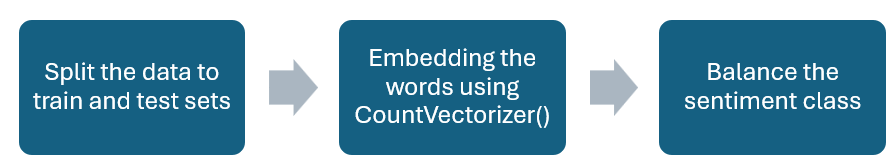

### 3.3.1 Downsampling the data

In [31]:
from sklearn.utils import resample

# Separate majority and minority classes
positive_sentiment = development[development["sentiment"] == 1]
negative_sentiment = development[development["sentiment"] == 0]

# Downsample majority class
positive_downsampled = resample(positive_sentiment,
                                 replace=False,  # sample without replacement
                                 n_samples=len(negative_sentiment),  # match minority class
                                 random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
development = pd.concat([positive_downsampled, negative_sentiment])
development_balanced = pd.concat([positive_downsampled, negative_sentiment])

In [32]:
development['sentiment'].value_counts()

1    1292
0    1292
Name: sentiment, dtype: int64

### 3.3.2 Stopwords removal

In [33]:
# Split the data into train 70% and test sets 30%
X = development_balanced["clean_text_stop_word"]
y = development_balanced['sentiment']

X_train, X_test, y_train_sw, y_test_sw = train_test_split(X , y, test_size=0.3, random_state=42)

# Vectorize the text using Bag of Words default parameters
vectorizer = CountVectorizer()
X_train_sw = vectorizer.fit_transform(X_train)
X_test_sw = vectorizer.transform(X_test)

### 3.3.3 Lemmatisation

In [34]:
# https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

# Split the data into train 70% and test sets 30%
X = development_balanced["clean_text_stop_lemma"]
y = development_balanced['sentiment']

X_train, X_test, y_train_lemma, y_test_lemma = train_test_split(X , y, test_size=0.3, random_state=42)

# Vectorize the text using Bag of Words default parameters
vectorizer = CountVectorizer()
X_train_lemma = vectorizer.fit_transform(X_train)
X_test_lemma = vectorizer.transform(X_test)

### 3.3.4 Lowering

In [35]:
# https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

# Split the data into train 70% and test sets 30%
X = development_balanced["clean_text_stop_lower"]
y = development_balanced['sentiment']

X_train, X_test, y_train_lower, y_test_lower = train_test_split(X , y, test_size=0.3, random_state=42)

# Vectorize the text using Bag of Words default parameters
vectorizer = CountVectorizer()
X_train_lower = vectorizer.fit_transform(X_train)
X_test_lower = vectorizer.transform(X_test)

### 3.4. Selecting supervised method for sentiment classification - Multinomial Naïve Bayes (MNB)

The reason to choose Multinomial Naïve Bayes is because MNB is very effective and fast in text classification. MNB  called "naive" because 
it assumes that the presence of a feature is independant to 
the presence of other features (Abbas et.al, 2019). Though, this may unrealistic in real world situation, MNB seems to perform well despite its simplicity and simplying assumption. 

In this sentiment analysis task, the important process are classifying the positive, neutral or negative sentiment given the hotel reviews and MNB can still effectively classifying text documents into those three sentiments eventhough with independence assumption. Plus, this hotel reviews in the development dataset has 10,000 reviews and MNB works best when dealing with large datasets.

### 3.4.1 Perform 10 Cross Validation

Perform a 10 fold cross validation for each dataset. This splits the training set (that we've used above) into 10 equal size subsets, and uses each in turn as the validation set while training a model with the other 9. We  should therefore have average rmse values for those 10 cross validation.

Accuracy will be used as the evaluation metric to measure which preprocessing dataset works best with the MNB model.

In [36]:
from sklearn.model_selection import cross_val_score

# Define the MNB model
mnb_cv=MultinomialNB()

cv_stop_word = cross_val_score(mnb_cv, 
    X_train_sw, y_train_sw, cv=10, scoring='accuracy').mean()
print("Accuracy in cross validation using stop words preprocessing: ",cv_stop_word)

cv_lemma = cross_val_score(mnb_cv, 
    X_train_lemma, y_train_lemma, cv=10, scoring='accuracy').mean()
print("Accuracy in cross validation using lemmatization preprocessing: ",cv_lemma)


cv_lower = cross_val_score(mnb_cv, 
    X_train_lower, y_train_lower, cv=10, scoring='accuracy').mean()
print("Accuracy in cross validation using lowering preprocessing: ",cv_lower)

Accuracy in cross validation using stop words preprocessing:  0.9364057704112951
Accuracy in cross validation using lemmatization preprocessing:  0.9297636586863106
Accuracy in cross validation using lowering preprocessing:  0.9314180478821361


### 3.4.2 Testing on test set

Multinomial Naive Bayes in Removal Stop Words:
Accuracy: 0.9265463917525774
F1 score: 0.9264516129032258
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       393
           1       0.92      0.94      0.93       383

    accuracy                           0.93       776
   macro avg       0.93      0.93      0.93       776
weighted avg       0.93      0.93      0.93       776

Multinomial Naive Bayes in Lemmatization:
Accuracy: 0.9226804123711341
F1 score: 0.9214659685863874
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       393
           1       0.92      0.92      0.92       383

    accuracy                           0.92       776
   macro avg       0.92      0.92      0.92       776
weighted avg       0.92      0.92      0.92       776

Multinomial Naive Bayes in Lowering the case:
Accuracy: 0.9239690721649485
F1 score: 0.9230769230769231
              precision    recall  f1

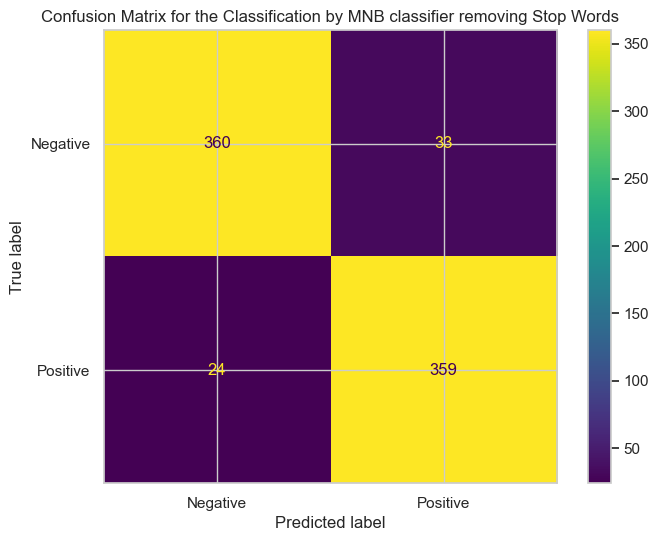

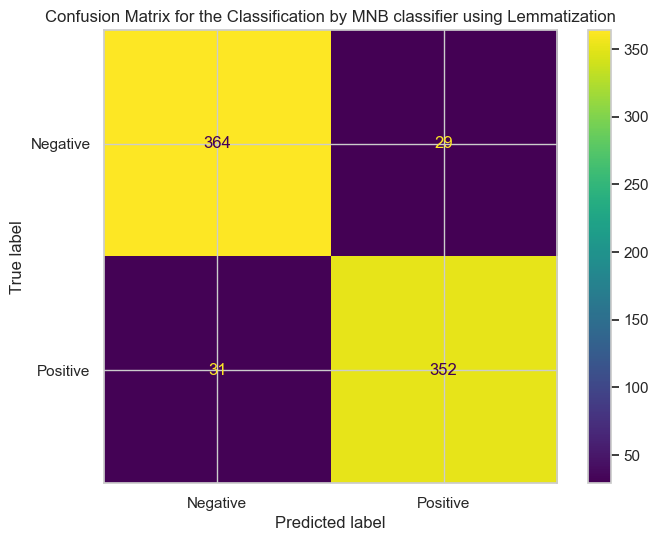

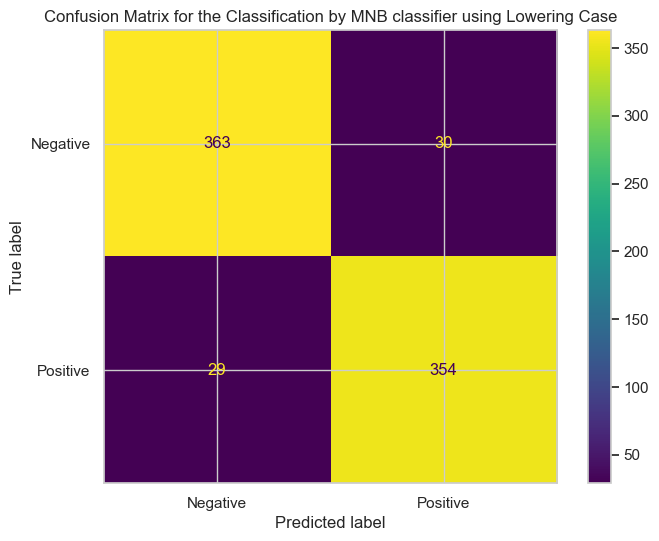

In [37]:
# Train a Multinomial Naive Bayes classifier default parameters

# Train and test on stop words
mnb_cv.fit(X_train_sw,y_train_sw)
y_pred_stop_word = mnb_cv.predict(X_test_sw)

# Train and test on lemmatization
mnb_cv.fit(X_train_lemma,y_train_lemma)
y_pred_lemma = mnb_cv.predict(X_test_lemma)

# Train and test on lower
mnb_cv.fit(X_train_lower,y_train_lower)
y_pred_lower = mnb_cv.predict(X_test_lower)

# Evaluation
print("Multinomial Naive Bayes in Removal Stop Words:")
print("Accuracy:", accuracy_score(y_test_sw, y_pred_stop_word))
print("F1 score:", f1_score(y_test_sw, y_pred_stop_word))
print(classification_report(y_test_sw, y_pred_stop_word))

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_test_sw, y_pred_stop_word),
                                display_labels=['Negative','Positive'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Classification by MNB classifier removing Stop Words')

 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

print("Multinomial Naive Bayes in Lemmatization:")
print("Accuracy:", accuracy_score(y_test_lemma, y_pred_lemma))
print("F1 score:", f1_score(y_test_lemma, y_pred_lemma))
print(classification_report(y_test_lemma, y_pred_lemma))

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_test_lemma, y_pred_lemma),
                                display_labels=['Negative','Positive'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Classification by MNB classifier using Lemmatization')

 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

print("Multinomial Naive Bayes in Lowering the case:")
print("Accuracy:", accuracy_score(y_test_lower, y_pred_lower))
print("F1 score:", f1_score(y_test_lower, y_pred_lower))
print(classification_report(y_test_lower, y_pred_lower))

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_test_lower, y_pred_lower),
                                display_labels=['Negative','Positive'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Classification by MNB classifier using Lowering Case')

 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

### 3.5. Comment on the best preprocessing - Removal Stop Words

The best preprocessing technique that works best with Multinomial Naïve Bayes (MNB) is removal of stop words with <b>0.940</b> of accuracy in the cross validation. On testing to the test set respectively, its shows that removal <b>stop words</b> registered the highest accuracy at <b>0.913</b>. There is no overfitting occured in the MNB model. This indicates that the model's performance is consistent across different datasets, suggesting good generalization on unseen data.

Notice all the accuracy are almost similar and close to each other with approximately around <b>90%</b> both on accuracy and F1-score. Bear in mind, MNB classifier emphasizing on the number of occurence of particular word given the class sentiments and it does so independently for each word, hence the "naive" assumption. Regardless the pre-processing method, the output yielded may not significantly affect the performance of MNB since it primarily relies on word occurrences rather than their context.

This method works best because it removes the <b>stop words</b>. <b>Stop words</b> are words commonly used in all sentences, so you can’t use them to make out any meaningful intents.

### 4. Sentiment classification using VADER lexicon

In [38]:
# Importing required libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Initializing the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Defining a function to get the sentiment score
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']


# Apply the function to the column of the DataFrame
development_balanced['compound'] = development_balanced["clean_text_stop_word"].apply(get_sentiment)

# Now will call out compound as a separate column and all values greater than 0.2 will be considered a positive review 
# and all values less than -0.2 would be considered as a negative review. The value between -0.2 to 0.2 is a neutral. 
# Followed (Chaithra V D, 2019) approached in analyzing sentiment of mobile unboxing video comment.

development_balanced['comp_score'] = development_balanced['compound'].apply(lambda c: 1 if c > 0.2 else (0 if c <= -0.2 else -1))

# To check the count of each classes
print(development_balanced['comp_score'].value_counts())

# Filter out -1 or Neutral comment
development_balanced = development_balanced[development_balanced['comp_score'] != -1]

development_balanced.head()

 1    2019
 0     460
-1     105
Name: comp_score, dtype: int64


,title,text,overall_rating,title_text,title_text_rm_non_alpha,tokenized_text,word_list_length,sentiment,detect_lang,clean_text_stop_word,clean_text_stop_lemma,clean_text_stop_lower,compound,comp_score
3538,“great location and fantastic views”,I stayed for just one night after good deal on...,5.0,“great location and fantastic views” I stayed ...,great location and fantastic views I stayed fo...,"[great, location, and, fantastic, views, I, st...",59,1,en,great location fantastic views I stayed one ni...,great location and fantastic view I stay for j...,great location and fantastic views i stayed fo...,0.9825,1
2176,"“Excellent location, clean, and fantastic staff”","This hotel is in a wonderful location, very cl...",4.0,"“Excellent location, clean, and fantastic staf...",Excellent location clean and fantastic staff T...,"[Excellent, location, clean, and, fantastic, s...",71,1,en,Excellent location clean fantastic staff This ...,excellent location clean and fantastic staff t...,excellent location clean and fantastic staff t...,0.9887,1
1219,“Nice but loud”,"Nice comfortable hotel, but our room was very ...",4.0,"“Nice but loud” Nice comfortable hotel, but ou...",Nice but loud Nice comfortable hotel but our r...,"[Nice, but, loud, Nice, comfortable, hotel, bu...",47,1,en,Nice loud Nice comfortable hotel room loud str...,nice but loud nice comfortable hotel but our r...,nice but loud nice comfortable hotel but our r...,0.9413,1
5096,“great 30th Bday!”,We recently stayed Feb 2011. The staff was fri...,5.0,“great 30th Bday!” We recently stayed Feb 2011...,great 30th Bday We recently stayed Feb 2011 Th...,"[great, 30th, Bday, We, recently, stayed, Feb,...",116,1,en,great 30th Bday We recently stayed Feb 2011 Th...,great 30th Bday we recently stay Feb 2011 the ...,great 30th bday we recently stayed feb 2011 th...,0.9894,1
3829,“Nice Clean Hotel”,This hotel lobby was very nice. All employees ...,4.0,“Nice Clean Hotel” This hotel lobby was very n...,Nice Clean Hotel This hotel lobby was very nic...,"[Nice, Clean, Hotel, This, hotel, lobby, was, ...",85,1,en,Nice Clean Hotel This hotel lobby nice All emp...,nice Clean Hotel this hotel lobby be very nice...,nice clean hotel this hotel lobby was very nic...,0.9669,1


### 4.1 Evaluate the sentiment classification using VADER lexicon

The Vader sentiment analysis tool doesn't provide a ground truth label for each sentence, so we cannot use accuracy directly. However, we can compare its output to manually labeled data to evaluate its performance using metrics like precision, recall, and F1-score. Using the manually labelled column - <b>sentiment</b>, we can compare with the <b>comp_score</b> that is measured by VADER lexicon.

Precision of Vader Lexicon: 0.6359583952451708
Recall of Vader Lexicon: 0.9992217898832685
F1-score of Vader Lexicon: 0.7772397094430993
              precision    recall  f1-score   support

           0       1.00      0.38      0.56      1194
           1       0.64      1.00      0.78      1285

    accuracy                           0.70      2479
   macro avg       0.82      0.69      0.67      2479
weighted avg       0.81      0.70      0.67      2479



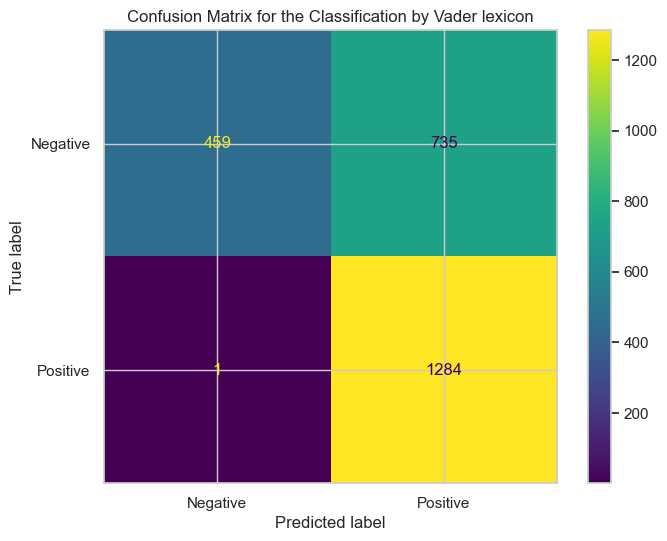

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Compute evaluation metrics
precision = precision_score(development_balanced["sentiment"], development_balanced["comp_score"])
recall = recall_score(development_balanced["sentiment"], development_balanced["comp_score"])
f1 = f1_score(development_balanced["sentiment"], development_balanced["comp_score"])

print("Precision of Vader Lexicon:", precision)
print("Recall of Vader Lexicon:", recall)
print("F1-score of Vader Lexicon:", f1)

print(classification_report(development_balanced["sentiment"], development_balanced["comp_score"]))

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(development_balanced["sentiment"], development_balanced["comp_score"]),
                                display_labels=['Negative','Positive'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Classification by Vader lexicon')

 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);


Even whent the class sentiment is balance between 0 and 1, the VADER lexicon still could not classified well for the negative statement. It had a low Recall registered <b>0.38</b> for negative sentiment while positive sentiment reached a perfect score of 1.

### 4.2. Comment on VADER lexicon method on dataset with stop words removal.

To begin with this dataset had positive sentiment of <b>1292</b> and negative sentiment had <b>1292</b> during the pre-processing in the supervised learning in the <b>section 3.4</b>. Then feed into VADER lexicon method, the VADER had classified positive sentiment of <b>2018</b> and negative sentiment had <b>461</b>, with removal of the neutral sentiment ie with <b>-1 (105) </b>score.

In term of accuracy, VADER Sentiment lexicon performed at <b>0.70</b>, lower than MNB accuracy registered at <b>0.91</b>. According to confusion matrix, VADER classified well for the positive statement with given the balanced of the sentiments and approximately 0.1% (2/1285) of the positive sentiment had been labelled wrong as negative. However, VADER had wrongly classified negative sentiment as positive with more than 60% and this reflect in the  Recall registered for negative sentiment, which is really low, registered at 0.38. 

Eventhough the Overall Recall is almost at perfect of 1, we need to be mindful that overall recall of VADER lexicon only account for the <b>True Positive</b>-1283 and <b>False Negative</b>-2.

In [40]:
pd.set_option('display.max_colwidth', None)

development_balanced[['title_text','clean_text_stop_word','sentiment','comp_score']].tail(5)

,title_text,clean_text_stop_word,sentiment,comp_score
9985,"“Worst Hyatt Regency I've ever stayed at” Stayed at many Hyatt's in different cities/countries. This one definitely left an impression, a very bad one. Dirty carpet, really old furniture. The whole room looks like it hasn't been cleaned properly. You can find a super-8 motel that was better than this. Stay away....",Worst Hyatt Regency Ive ever stayed Stayed many Hyatts different citiescountries This one definitely left impression bad one Dirty carpet really old furniture The whole room looks like hasnt cleaned properly You find super8 motel better Stay away,0,0
9987,“Will not return to this hotel” We stayed here overnight before a SD Chargers game. Worst place to stay! The hotel smelled of smoke. The TV didn't work. We were put right next to the elevator. Our neighbors took a shower at 4:30 in the morning and we heard every bit of it. The walls are VERY thin and you can hear everyone coming and going. The resturant looked dingy. We will look into another location for our upcoming games.,Will return hotel We stayed overnight SD Chargers game Worst place stay The hotel smelled smoke The TV didnt work We put right next elevator Our neighbors took shower 430 morning heard every bit The walls VERY thin hear everyone coming going The resturant looked dingy We look another location upcoming games,0,0
9990,"“THIN walls” I had read that the walls were thin, but chose to ignore the warning from other tripadvisors... We felt as we were sharing the same room with little children next door. Arrived on a Friday for a long romantic weekend stay. Booked a river view room. You get what you pay for...(overlooked a bridge and partial river). There are many other wonderful hotels to stay in that are much nicers. Windows do not open and there are no balconies. Our room was on the 2nd floor, next to a family with young children. The noise level was so high, I requested to change the room but was advised all river views were booked for the weekend. ** A note to management would be that no couple or single traveler should have a room next to a family with children. There should be a separate floor so all the noise they make will be acceptable. TV was on 24 hours and loud! The only night we had that was acceptable was Sunday night as our neighbors had left. There is a english pub on the river walk directly below which on weekends becomes a night club. I was glad I had ear plugs. Could actually hear the noise with the plugs in. I was very disappointed with the Hyatt. Cleanliness was not so good either. I was sitting in the chair reading and could clearly see the dust (when you can write your name in it). No one dusted here. A decorative pillow fell behind the chair and was not picked up until I picked it up. I guess housekeeping does not really move anything. Advice to future travelers they are many hotels on the riverwalk, review, review, review and then make sure when you book make sure you the paying customer are satisfied.",THIN walls I read walls thin chose ignore warning tripadvisors We felt sharing room little children next door Arrived Friday long romantic weekend stay Booked river view room You get pay foroverlooked bridge partial river There many wonderful hotels stay much nicers Windows open balconies Our room 2nd floor next family young children The noise level high I requested change room advised river views booked weekend A note management would couple single traveler room next family children There separate floor noise make acceptable TV 24 hours loud The night acceptable Sunday night neighbors left There english pub river walk directly weekends becomes night club I glad I ear plugs Could actually hear noise plugs I disappointed Hyatt Cleanliness good either I sitting chair reading could clearly see dust write name No one dusted A decorative pillow fell behind chair picked I picked I guess housekeeping really move anything Advice future travelers many hotels riverwalk review re

Few factors that make VADER did not perform well. Lets take the example above where the VADER classified positive for the negative statement using the development dataset of removing stop words.

The way VADER calculated is by how many positive or negative or neutral present in the sentences. Even though words like <b>I was very disappointed with the Hyatt</b>, <b>Cleanliness was not so good either</b> and <b> No one dusted here</b> are negative words, its possible large numbers of phrases with positive connotations might have influenced the VADER classification. 

Next, in this situation, removing stop words from the dataset had failed VADER to capture the negative connotation ie the true sentiment. This suggested that VADER lexicon may fail to capture the negative sentiment if it did not expressed distinctly. 

As mentioned in Mërgim H. & Ajdari Jaumin (2023) paper, VADER model application was founded found out in research of by Hutto, C.J. & Gilbert, E.E. They have created a lexicon of the English language containing 7520 
different terms using social media text, which often contains informal language, slang, and misspellings. Therefore, it includes a wide range of words, including variations of words and emoticons commonly used in online communication.

However, in this hotel review dataset, the accuracy might be low due to words in the reviews are not present in the VADER built-in lexicon. This shows that hotel reviews words does not have the same lingo as per social media text, hence it failed to capture the nuance of the sentence.

Overall, given VADER lexicon performed at <b> 0.70</b>, the process is much faster.

### 5. Combining VADER with the best classifier

This hotel dataset does not have labelled column indicating the review as positive or negative in order to train the MNB classifier. Hence, utilising the lexicon based approach using Valence Aware Dictionary for sEntiment Reasoning (VADER) would categorized the reviews as positive, negative and neutral. The important feature of VADER is assigning the not just the polarity of the reviews but the intensity as well. The output VADER will give 4 values which are <b>pos</b>, <b>neg</b>, <b>neu</b> and <b>compound</b> ranging from -1 to 1 ie to tell how intense is the reviews. 

Using the dataset from <b>section 3.4</b>, where initially the dataset has a balanced class within positive and negative sentiment which is <b>1292</b> respectively.

Workflow below is followed from Chaithra V D (2019) in his article titled, <b>Hybrid approach: naive bayes and sentiment VADER for analyzing sentiment of mobile unboxing video comments </b>. In the paper, for the VADER compound score,  all values greater than 0.2 will be considered a positive review and all values less than -0.2 would be considered as a negative review. The value between -0.2 to 0.2 is a neutral. 

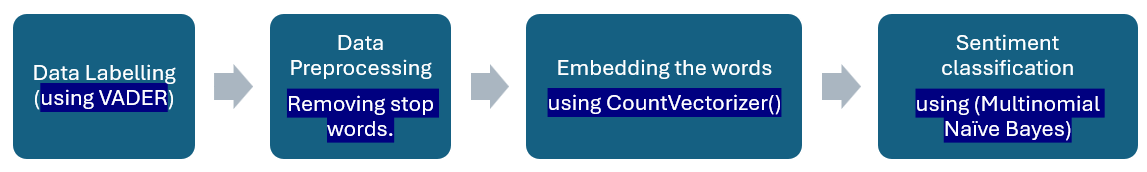

### 5.1 Data Labelling with VADER lexicon

In [41]:
# Initializing the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Defining a function to get the sentiment score
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

# Apply the function to the column of the DataFrame
development['compound'] = development["title_text_rm_non_alpha"].apply(get_sentiment)

# Now will call out compound as a separate column and all values greater than 0.2 will be considered a positive review 
# and all values less than -0.2 would be considered as a negative review. The value between -0.2 to 0.2 is a neutral. 
# Followed (Chaithra V D, 2019) approached in analyzing sentiment of mobile unboxing video comment.

development['comp_score'] = development['compound'].apply(lambda c: 1 if c > 0.2 else (0 if c <= -0.2 else -1))

print(development['comp_score'].value_counts())

# Filter out -1 or Neutral comment
development = development[development['comp_score'] != -1]

development[development['sentiment']== 0].head(10)

 1    1891
 0     591
-1     102
Name: comp_score, dtype: int64


,title,text,overall_rating,title_text,title_text_rm_non_alpha,tokenized_text,word_list_length,sentiment,detect_lang,clean_text_stop_word,clean_text_stop_lemma,clean_text_stop_lower,compound,comp_score
0,“Horrible experience”,"First of all we got there and they didn't have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own ""policies"" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon't ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and moving from state to state we know about hotels and excellent customer service) \n(Oh yeah no free breakfast either)",1.0,"“Horrible experience” First of all we got there and they didn't have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own ""policies"" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon't ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and moving from state to state we know about hotels and excellent customer service) \n(Oh yeah no free breakfast either)",Horrible experience First of all we got there and they didnt have the room we booked did not pay us the difference from the room we booked to the cheaper one they gave us STAFF took forever to address our problem not KID friendly pool dirty and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY\nWe thought by paying more we would get a good deal well this hotel is not the case\n400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business They are giving SHERATON a horrible reputation I guess they are managed by SHERATON but have their own policies and undesirable customer service\nGreat time in San Diego but a nightmare of a hotel\nDont ever write reviews but this one was called for if you can avoid this hotel do it\nBeing a military family and moving from state to state we know about hotels and excellent customer service \nOh yeah no free breakfast either,"[Horrible, experience, First, of, all, we, got, there, and, they, didnt, have, the, room, we, booked, did, not, pay, us, the, difference, from, the, room, we, booked, to, the, cheaper, one, they, gave, us, STAFF, took, forever, to, address, our, problem, not, KID, friendly, pool, dirty, and, parking, wow, good, luck, going, somewhere, at, night, time, and, come, back, to, the, hotel, to, try, to, find, a, parking, 

### 5.2 Removing stop words

In [42]:
# lets clean the data 
def clean_text_stop_word(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = stopwords.words("english")
    filtered_tokens =  [word for word in tokens if word not in stop_words]
    text1 = " ".join(filtered_tokens)
    
    # Return the cleaned text as a string
    return text1

# Apply the function to the text column
development["clean_text_stop_word_after_vader"] =  development['title_text_rm_non_alpha'].apply(clean_text_stop_word)

In [43]:
development

,title,text,overall_rating,title_text,title_text_rm_non_alpha,tokenized_text,word_list_length,sentiment,detect_lang,clean_text_stop_word,clean_text_stop_lemma,clean_text_stop_lower,compound,comp_score,clean_text_stop_word_after_vader
3538,“great location and fantastic views”,"I stayed for just one night after good deal on priceline - !20 per night. I had a great room on the 28th floor with a fantastic location of the city. The hotel itself is really close to everything you might need - shops and eating and business. The staff were friendly and helpful. Overall, great!",5.0,"“great location and fantastic views” I stayed for just one night after good deal on priceline - !20 per night. I had a great room on the 28th floor with a fantastic location of the city. The hotel itself is really close to everything you might need - shops and eating and business. The staff were friendly and helpful. Overall, great!",great location and fantastic views I stayed for just one night after good deal on priceline 20 per night I had a great room on the 28th floor with a fantastic location of the city The hotel itself is really close to everything you might need shops and eating and business The staff were friendly and helpful Overall great,"[great, location, and, fantastic, views, I, stayed, for, just, one, night, after, good, deal, on, priceline, 20, per, night, I, had, a, great, room, on, the, 28th, floor, with, a, fantastic, location, of, the, city, The, hotel, itself, is, really, close, to, everything, you, might, need, shops, and, eating, and, business, The, staff, were, friendly, and, helpful, Overall, great]",59,1,en,great location fantastic views I stayed one night good deal priceline 20 per night I great room 28th floor fantastic location city The hotel really close everything might need shops eating business The staff friendly helpful Overall great,great location and fantastic view I stay for just one night after good deal on priceline 20 per night I have a great room on the 28th floor with a fantastic location of the city the hotel itself be really close to everything you might need shop and eating and business the staff be friendly and helpful overall great,great location and fantastic views i stayed for just one night after good deal on priceline 20 per night i had a great room on the 28th floor with a fantastic location of the city the hotel itself is really close to everything you might need shops and eating and business the staff were friendly and helpful overall great,0.9825,1,great location fantastic views I stayed one night good deal priceline 20 per night I great room 28th floor fantastic location city The hotel really close everything might need shops eating business The staff friendly helpful Overall great
2176,"“Excellent location, clean, and fantastic staff”","This hotel is in a wonderful location, very close to Fells Point and the Shot Tower, in a beautiful brick building surrounded by other historic structures and good restaurants. \nIt's true; the parking is expensive, but I didn't need parking, and what would you expect from such a central location? \nThe fitness room was great as well, and the breakfast well run. \nWould easily recommend.",4.0,"“Excellent location, clean, and fantastic staff” This hotel is in a wonderful location, very close to Fells Point and the Shot Tower, in a beautiful brick building surrounded by other historic structures and good restaurants. \nIt's true; the parking is expensive, but I didn't need parking, and what would you expect from such a central location? \nThe fitness room was great as well, and the breakfast well run. \nWould easily recommend.",Excellent location clean and fantastic staff This hotel is in a wonderful location very close to Fells Point and the Shot Tower in a beautiful brick building surrounded by other historic structures and good restaurants \nIts true the parking is expensive but I didnt need parking and what would you expect from such a central location \nThe fitness

### 5.3 Split the data and Embedding the words

In [44]:
# Split the data into train 70% and test sets 30%
X = development["clean_text_stop_word_after_vader"] 
y = development['comp_score'] 

print(len(X))

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3, random_state=42)

print(len(X_train),len(X_test))

# Vectorize the text using Bag of Words default parameters
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

2482
1737 745


In [45]:
y_train.value_counts()

1    1334
0     403
Name: comp_score, dtype: int64

### 5.4 Balancing the dataset given the sentiment class using SMOKE

Handling Imbalance target feature-SMOTE
We noticed that we got a lot of positive sentiments compared to negative. So it is crucial to balanced the classes in such situation. Here I use SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem.It aims to balance class distribution by randomly increasing minority class examples by replicating them.

SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [46]:
# https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

print(f'Original dataset shape : {Counter(y_train)}')

smote = SMOTE(random_state=42)
X_res_train_stop_word, y_res_train_stop_word = smote.fit_resample(X_train, y_train)

print(f'Resampled dataset shape in train set {Counter(y_res_train_stop_word)}')


print(f'Original dataset shape : {Counter(y_test)}')

smote = SMOTE(random_state=42)
X_res_test_stop_word, y_res_test_stop_word = smote.fit_resample(X_test, y_test)

print(f'Resampled dataset shape in test set {Counter(y_res_test_stop_word)}')

Original dataset shape : Counter({1: 1334, 0: 403})
Resampled dataset shape in train set Counter({1: 1334, 0: 1334})
Original dataset shape : Counter({1: 557, 0: 188})
Resampled dataset shape in test set Counter({1: 557, 0: 557})


### 5.5 Perform 10 cross validation

In [47]:
# Define the MNB model
mnb_vader=MultinomialNB()

mnb_vader_sw = cross_val_score(mnb_vader, 
    X_res_train_stop_word, y_res_train_stop_word, cv=10, scoring='accuracy').mean()
print("Accuracy in cross validation using lemmatization preprocessing: ",mnb_vader_sw)

Accuracy in cross validation using lemmatization preprocessing:  0.8800808200275971


### 5.6 Train and test the MNB classifier

Multinomial Naive Bayes with Vader Lexicon:
Accuracy: 0.8859964093357271
Recall: 0.9156193895870736
F1 score: 0.889276373147341
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       557
           1       0.86      0.92      0.89       557

    accuracy                           0.89      1114
   macro avg       0.89      0.89      0.89      1114
weighted avg       0.89      0.89      0.89      1114



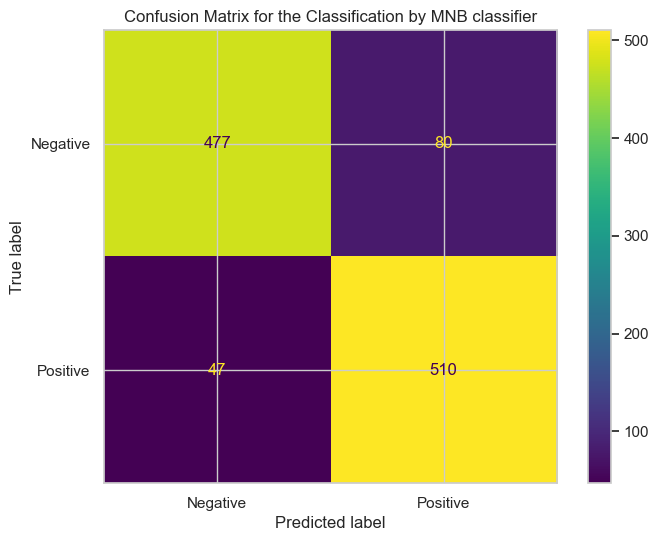

In [48]:
# Train a Multinomial Naive Bayes classifier default parameters

# Train and test on lemmatization
mnb_vader.fit(X_res_train_stop_word, y_res_train_stop_word)
y_pred = mnb_vader.predict(X_res_test_stop_word)


print("Multinomial Naive Bayes with Vader Lexicon:")
print("Accuracy:", accuracy_score(y_res_test_stop_word, y_pred))
print("Recall:",recall_score(y_res_test_stop_word,y_pred))
print("F1 score:", f1_score(y_res_test_stop_word, y_pred))
print(classification_report(y_res_test_stop_word, y_pred))

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_res_test_stop_word, y_pred),
                                display_labels=['Negative','Positive'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Classification by MNB classifier')

 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);


Using the workflow above, combination of VADER and MNB classifier reached an accuracy of <b>0.87</b>. The combination of lexicon and supervised learning is performing very well which is in between of earlier models which are the MNB classifier from <b> section 3.5.2</b> with <b>0.91</b> accuracy while VADER lexicon, from <b> section 4.1</b> with <b>0.70</b> accuracy. 

After the VADER had labelled the data into positive and negative, the classes were not balanced, hence SMOKE was applied. SMOKE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. In the <b>section 5.4</b>, it shows that negative sentiment was bumped up from <b> 179 </b> to <b>566</b>.

Out of <b>566</b> negative reviews in the test dataset <b>474</b> were correctly predicted as negative class and <b>92</b> were predicted positive but was negative. With <b>566</b> positive comments in the test dataset <b>512</b> were predicted as positive and <b>54</b> predicted negative but was positive.

Rule based lexicon approach Sentiment VADER was applied to label the reviews. In order to perform binary classification neutral comments were removed and the Naive Bayes classifier was trained with <b>70%</b> of the data. The classifier was then tested on the <b>30%</b> unseen data and an accuracy of <b>87.10%</b> and F1 Score of <b>87.5%</b> was achieved.

This shows that VADER lexicon using social media text give a good affect the MNB classifier is predicting the sentiment.

### 6. Training and testing the final method

### 6.1 Data Labelling with VADER lexicon

In [49]:
# Initializing the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Defining a function to get the sentiment score
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

# Apply the function to the column of the DataFrame
train['compound'] = train["title_text_rm_non_alpha"].apply(get_sentiment)

# Now will call out compound as a separate column and all values greater than 0.2 will be considered a positive review 
# and all values less than -0.2 would be considered as a negative review. The value between -0.2 to 0.2 is a neutral. 
# Followed (Chaithra V D, 2019) approached in analyzing sentiment of mobile unboxing video comment.

train['comp_score'] = train['compound'].apply(lambda c: 1 if c > 0.2 else (0 if c <= -0.2 else -1))

print(train['comp_score'].value_counts())

# Filter out -1 or Neutral comment
train = train[train['comp_score'] != -1]

train

 1    8932
 0     866
-1     202
Name: comp_score, dtype: int64


,title,text,overall_rating,title_text,title_text_rm_non_alpha,compound,comp_score
10000,“Nice hotel - great location”,This was a nice hotel for the price I got at the last minute on Expedia. The staff was very friendly. I had a nice dinner at PJ Clarke's across the street. The location of this hotel is great. Walking distance to everything. Cabs everywhere. The room was quite small but I wasn't there long enough to really care. It was clean and comfortable!,4.0,“Nice hotel - great location” This was a nice hotel for the price I got at the last minute on Expedia. The staff was very friendly. I had a nice dinner at PJ Clarke's across the street. The location of this hotel is great. Walking distance to everything. Cabs everywhere. The room was quite small but I wasn't there long enough to really care. It was clean and comfortable!,Nice hotel great location This was a nice hotel for the price I got at the last minute on Expedia The staff was very friendly I had a nice dinner at PJ Clarkes across the street The location of this hotel is great Walking distance to everything Cabs everywhere The room was quite small but I wasnt there long enough to really care It was clean and comfortable,0.9744,1
10001,“Perfect location and the room was generous in size.”,I stayed in this hotel in December of 2010 and again in February as I traveled to NYC for Fashion Week. I love the location and it offers a nice energy level without feeling chaotic or like it is trying too hard. Norma's is an absolute must and the perfect way to start each day.,4.0,“Perfect location and the room was generous in size.” I stayed in this hotel in December of 2010 and again in February as I traveled to NYC for Fashion Week. I love the location and it offers a nice energy level without feeling chaotic or like it is trying too hard. Norma's is an absolute must and the perfect way to start each day.,Perfect location and the room was generous in size I stayed in this hotel in December of 2010 and again in February as I traveled to NYC for Fashion Week I love the location and it offers a nice energy level without feeling chaotic or like it is trying too hard Normas is an absolute must and the perfect way to start each day,0.9725,1
10002,"“Rude staff, extra charges, overall unimpressive”","We traveled here with a big group for a wedding the weekend of the 16th. Immediately upon check-in the man at the front desk was lazy, uninterested and every little question regarding the reservation seemed to bother him. The woman was SO rude. She looked at us like we were scum, it was horrible. We had been booked into a non-smoking room and after some coaxing we got him to move us. Joey was nice but later when we had problems with overcharging it was like a completely different person. Definitely not in a good way. \nGood: The room was clean and the bar staff was SO much fun. We spent a lot of time in there and the manager was so great. He remembered us and joked with us, that was a truly nice experience. Buzz the bartender is so sweet also. I left my card there (never closed my tab! Yikes!) and they had no problem mailing it to me ALL the way in Colorado). I even saw the woman from Front Desk go into the bar after her shift for a few drinks and she seemed very capable of kindness then but spared none for us guests.\nThe hotel is nice overrall but seemed a little sad. Really enjoyed the 8ft deep pool and hot tub. When we got home however, they had charged us for 2 rooms even though we only stayed in one and there were 6 other mysterious 100+ dollar charges which the Front Desk people still haven't been figured out. If it wasn't for the bar and it's staff, I would rate this place as Terrible.",2.0,"“Rude staff, extra charges, overall unimpressive” We traveled here with a big group for a wedding the weekend of the 16th. Immediately upon check-in the man at the front desk was lazy, uninterested and every little question regarding the reservation seemed to bother him. The woman was SO rude. 

### 6.1.2 Removing stop words

In [50]:
# lets clean the data 
def clean_text_stop_word(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = stopwords.words("english")
    filtered_tokens =  [word for word in tokens if word not in stop_words]
    text1 = " ".join(filtered_tokens)
    
    # Return the cleaned text as a string
    return text1

# Apply the function to the text column
train["clean_text_stop_word"] =  train['title_text_rm_non_alpha'].apply(clean_text_stop_word)

### 6.1.3 Balance the dataset for the training phase

In [51]:
from sklearn.utils import resample

# Separate majority and minority classes
positive_sentiment = train[train["comp_score"] == 1]
negative_sentiment = train[train["comp_score"] == 0]

# Upsample minority class
negative_upsampled = resample(negative_sentiment,
                                 replace=True,  # sample without replacement
                                 n_samples=len(positive_sentiment),  # match minority class
                                 random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
train_balanced = pd.concat([negative_upsampled, positive_sentiment])

In [52]:
train_balanced['comp_score'].value_counts()

0    8932
1    8932
Name: comp_score, dtype: int64

### 6.1.4 Embedding the train set words

In [53]:
# Split the data into train 70% and test sets 30%
X = train_balanced["clean_text_stop_word"] 
y = train_balanced['comp_score'] 

print(len(X))

# Vectorize the text using Bag of Words default parameters
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X)

17864


### 6.1.5 Perform 10 cross validation

In [54]:
# Define the MNB model
mnb_vader=MultinomialNB()

mnb_vader_sw = cross_val_score(mnb_vader, 
    X_train, y, cv=10, scoring='accuracy').mean()
print("Accuracy in cross validation removing stop words preprocessing: ",mnb_vader_sw)

Accuracy in cross validation removing stop words preprocessing:  0.9391510542420656


### 6.1.6 Train and test with MNB classifier

In [55]:
# Train on MNB classifier removing stop words
mnb_vader.fit(X_train, y)

MultinomialNB()

In [56]:
# Apply the VADER classification on test set
sia = SentimentIntensityAnalyzer()

# Defining a function to get the sentiment score
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

# Apply the function to the column of the DataFrame
test['compound'] = test["title_text_rm_non_alpha"].apply(get_sentiment)

# Now will call out compound as a separate column and all values greater than 0.2 will be considered a positive review 
# and all values less than -0.2 would be considered as a negative review. The value between -0.2 to 0.2 is a neutral. 
# Followed (Chaithra V D, 2019) approached in analyzing sentiment of mobile unboxing video comment.

test['comp_score'] = test['compound'].apply(lambda c: 1 if c > 0.2 else (0 if c <= -0.2 else -1))

# Filter out -1 or Neutral comment
test = test[test['comp_score'] != -1]

# Apply the removal stop words function to the text column
test["clean_text_stop_word"] =  test['title_text_rm_non_alpha'].apply(clean_text_stop_word)

# Apply the Vectorizer to the words
X_test = test["clean_text_stop_word"]
y_test = test["comp_score"]

X_test = vectorizer.transform(X_test)

Multinomial Naive Bayes with Vader Lexicon:
Accuracy: 0.9211330751986957
Recall: 0.9363737486095662
F1 score: 0.9560477001703578
              precision    recall  f1-score   support

           0       0.52      0.75      0.62       824
           1       0.98      0.94      0.96      8990

    accuracy                           0.92      9814
   macro avg       0.75      0.85      0.79      9814
weighted avg       0.94      0.92      0.93      9814



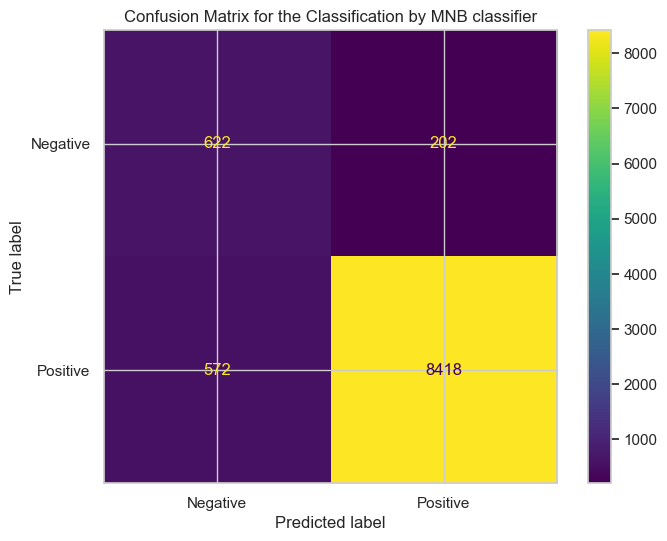

In [57]:
# Test a Multinomial Naive Bayes classifier default parameters

y_pred = mnb_vader.predict(X_test)

print("Multinomial Naive Bayes with Vader Lexicon:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test,y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                                display_labels=['Negative','Positive'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Classification by MNB classifier')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

Use the best overall method from point 5 to preprocess the training/test sets. Note, that your preprocessing should be unsupervised, that is, cannot use the target attribute.

Using the workflow in <b>section</b>, the method is applied on to the next 10,000 training set and 10,000 testing set. The VADER lexicon method and removing stop words had been applied on it. Later, the unbalanced classified sentiment by VADER is had been solved by upsampling the minority class ie the negative sentiment classs.

Then, its ready for training with Multinomial Naive Bayes (MNB) classifier. Using 10 cross validation process, the training set reached a <b>94%</b> accuracy.

Next, the fitted MNB model is then tested with testing set without the balancing the sentiment class so we could see the model's performance either is able to evaluate on unseen data. It is important to maintain the original distribution of classes in the test set in order to see the model's ability how well in generalizing the unseen data.

This model reached an accuracy of <b>92%</b> and this hugely contribute by the model's ability to predict the positive class. Though with high accuracy, the Recall score on negative sentiment registered lower with <b>0.75</b>. This is shows that the model is slighly fall through in classifying the negative sentiment and this may be contribution by the VADER lexicon method. This situation reflect similar in the <b>section 5.6</b>, where the Recall score for negative sentiment registered lower.

However, in this hotel review dataset, the accuracy might be low due to words in the reviews are not present in the VADER built-in lexicon. This shows that hotel reviews words does not have the same lingo as per social media text, hence it failed to capture the nuance of the sentence. Going forwards, perhaps needs more robust lexicon that have hotel covered reviews type of opinion extensively.

    
Overall, this model accuracy performed very well with highest accuracy than in <b>section 5.6 - 87%</b>, <b>section 4.1 - 70%</b> and <b>section 3.4.2 - 91%</b>.

### 7. Reviews aspect prediction

Aspect based level sentiment is vitally focus whats in the opinion in that consist the sentiment and a target(Chaithra V D, 2019). Typically, aspect sentiment is performed to measure how two different products getting more positive or negative feedback given their features (Chaithra V D, 2019). In Chaitrhra article also mentioned about the work by  Y.Han et al. where he proposed, using sentence pattern which utlized the aspect based level sentiment lexicon can increase the model accuracy. This aspect based level might work better in our VADER lexicon in classifying the hotel reviews dataset since VADER also works on lexicon basis.

As per hotel reviews dataset, the aspect sentiment focus on details of the opinion leaved by the hotel guests of what they had felt over their staying in the particular hotel. For instance, The reviewer might give the hotel a positive overall rating, but mention that the room service was poor. In this case, the aspect/target is <b>"service"</b> and opinion is <b>"poor"</b> because it very subjective. It would be useful to know that the sentiment towards the aspect “service” is negative, even though the overall sentiment is positive. Hence using Aspect Based Sentiment Analysis (ABSA), we can know what aspect of the hotel that reviews are talking about, do people have a pleasant or unpleasant stay at the hotel or maybe any constructive feedback that can boost the hotel reputation.

There are a number of ways to approach ABSA, but one common approach is to first identify aspects in text, and then use an ABSA model to label the sentiment of each aspect. The process of aspect prediction for hotel dataset reviews had followed 

from medium website article by <b>Fabio Chiusano</b> with title <b>Quick intro to Aspect-Based Sentiment Analysis</b>.

First, in order to identify aspects in text, in data pre-processing, we can perform the tokenization, lowering case, removing the stop words and finally the stemming or lemmatization. Since the aspect based level is more concentrate on word basis, is it important to clean the word beforehand.

Next, we need classify sentiment of an aspect relative to a sentence as context ie we need to have like a dictionary map indicating that this aspect belong to this sentiment/opinion. For instance in the sentence:

"Nice hotel great location This was a nice hotel for the price I got at the last minute on Expedia The staff was very friendly"

with aspect <b>"hotel"</b> and label <b>"positive"</b>, because the sentence referring to <b>nice hotel</b>.

with aspect <b>"location"</b> and label <b>"positive"</b>, because the sentence referring to <b>great location</b>.

with aspect <b>"staff</b>" and label <b>"positive"</b>, because the setence referring to <b>staff was very friendly</b>.

We need a model train all these dataset for the classifier to capture the aspect of the reviews robustly. There is available public pre-trained model called <b>DeBERTa fine-tuned over ABSA datasets</b> instead of training a model from scratch.

Finally, we can split the data into train and test set. We can train the data using the pre-trained model and compute sentiment towards specific aspects in a given context sentence using the test set.

### 8. References

Abbas, Muhammad & Ali, Kamran & Memon, Saleem & Jamali, Abdul & Memon, Saleemullah & Ahmed, Anees, 2019, 'Multinomial Naive Bayes Classification Model for Sentiment Analysis', International Journal of Computer Science and Network Security. vol. 19 no. 3, pp. 62-67.

Beri, A 2020, Sentiment Analysis Using VADER, viewed 22 March 2024, https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

Chaithra, VD 2019, ‘Hybrid approach: naive bayes and sentiment VADER for analyzing sentiment of mobile unboxing video comments’, International Journal of Power Electronics and Drive Systems, vol. 9, no. 5, pp. 4452-.

Chiusano, F 2022, Quick intro to Aspect-Based Sentiment Analysis, viewed 29 March 2024, https://medium.com/nlplanet/quick-intro-to-aspect-based-sentiment-analysis-c8888a09eda7.

datacarpentry.org, (n.d.), Data Analysis and Visualization in Python for Ecologists: Indexing, Slicing and Subsetting DataFrames in Python, viewed 23 March 2024, https://datacarpentry.org/python-ecology-lesson/03-index-slice-subset.html.

Fuller, D 2020, Creating Visuals with NLTK’s FreqDist, viewed 22 March 2024, https://dariuslfuller.medium.com/creating-visuals-with-nltks-freqdist-ac4e667e49f3


hex.tech. (n.d.). VADER sentiment analysis (with examples), viewed 24 March 2024, https://hex.tech/use-cases/sentiment-analysis/vader-sentiment-analysis/

Hoti Mërgim H. & Ajdari Jaumin 2023, ‘Sentiment Analysis Using the Vader Model for Assessing Company Services Based on Posts on Social Media’, SEEU Review, vol. 18, no. 2, pp. 19–33.

MonkeyLearn (n.d.), Sentiment Analysis Guide, viewed 21 March 2024, https://monkeylearn.com/sentiment-analysis/#:~:text=Sentiment%20analysis%2C%20otherwise%20known%20as

Stack Overflow, (n.d.), How to read a JSON file with nested objects as a pandas DataFrame?, viewed 22 March 2024, https://stackoverflow.com/questions/40588852/how-to-read-a-json-file-with-nested-objects-as-a-pandas-dataframe [Accessed 31 Mar. 2024]

Stack Overflow, (n.d.), regular expression ‘.*[^a-zA-Z0-9_].*’, viewed 22 March 2024, https://stackoverflow.com/questions/10868308/regular-expression-a-za-z0-9

Stack Overflow, (n.d.), Why is my legend in my seaborn countplot not showing all the labels?, viewed 22 March 2024, https://stackoverflow.com/questions/61445146/why-is-my-legend-in-my-seaborn-countplot-not-showing-all-the-labels?newreg=89c6cf35d91643509d6c0c57733a149e

Stack Overflow, (n.d.), Drop Non English Rows Pandas, viewed 23 March 2024, https://stackoverflow.com/questions/69804094/drop-non-english-rows-pandas

Sujanmulk, P 2021, Sentiment Analysis on Amazon Reviews using TF-IDF Approach, viewed 22 March 2024, https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

Wells R, (n.d.), Upsampling and Downsampling Imbalanced Data in Python, viewed 22 March 2024, https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/ [Accessed 31 Mar. 2024].